<h1 style="font-family:Georgia, serif;color:black" align='Center'> CREDIT CARD LEAD PREDICTION </h1>

<h4 style="font-family:Georgia, serif;color:black" align='justify'>First and foremost, I'd like to express my gratitude for allowing me to take part in this hackathon. I've explained each line of code here, and I've also attached the detailed explanation in a solution file.</h4>

<h4 style="font-family:Georgia, serif;color:blue" align='Left'>Importing the necessary libraries and datasets</h4> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
le = LabelEncoder()
pca=PCA()
sc=StandardScaler()

import tensorflow as tf
from tensorflow import keras
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

import random
import os
import time


df_train = pd.read_csv('train_s3TEQDk.csv')
df_test = pd.read_csv('test_mSzZ8RL.csv')
df_sample = pd.read_csv('sample_submission_eyYijxG.csv')

<h4 style="font-family:Georgia, serif;color:blue" align='Left'>Exploring the dataset in order to construct the model</h4> 

In [2]:
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
df_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [5]:
df_train.shape, df_test.shape

((245725, 11), (105312, 10))

In [6]:
df_train.isnull().sum(), df_test.isnull().sum()

(ID                         0
 Gender                     0
 Age                        0
 Region_Code                0
 Occupation                 0
 Channel_Code               0
 Vintage                    0
 Credit_Product         29325
 Avg_Account_Balance        0
 Is_Active                  0
 Is_Lead                    0
 dtype: int64,
 ID                         0
 Gender                     0
 Age                        0
 Region_Code                0
 Occupation                 0
 Channel_Code               0
 Vintage                    0
 Credit_Product         12522
 Avg_Account_Balance        0
 Is_Active                  0
 dtype: int64)

In [7]:
#Finding the n-unique values in a categorical data
for col in df_train.select_dtypes('object').columns:
    print(col, df_train[col].nunique())

ID 245725
Gender 2
Region_Code 35
Occupation 4
Channel_Code 4
Credit_Product 2
Is_Active 2


In [8]:
for i in df_train:
    print(f'{i} : {df_train[i].unique()}')

ID : ['NNVBBKZB' 'IDD62UNG' 'HD3DSEMC' ... 'GEHAUCWT' 'GE7V8SAH' 'BOCZSWLJ']
Gender : ['Female' 'Male']
Age : [73 30 56 34 62 48 40 55 53 27 31 79 33 46 59 65 37 44 32 50 70 25 52 26
 67 29 41 49 63 61 64 60 76 57 36 28 58 43 35 71 82 45 42 54 47 78 51 68
 83 39 84 24 38 74 81 69 75 85 66 80 72 77 23]
Region_Code : ['RG268' 'RG277' 'RG270' 'RG282' 'RG261' 'RG265' 'RG283' 'RG254' 'RG269'
 'RG257' 'RG279' 'RG280' 'RG252' 'RG284' 'RG259' 'RG281' 'RG258' 'RG266'
 'RG260' 'RG274' 'RG256' 'RG275' 'RG273' 'RG267' 'RG272' 'RG251' 'RG262'
 'RG264' 'RG278' 'RG276' 'RG263' 'RG250' 'RG255' 'RG253' 'RG271']
Occupation : ['Other' 'Salaried' 'Self_Employed' 'Entrepreneur']
Channel_Code : ['X3' 'X1' 'X2' 'X4']
Vintage : [ 43  32  26  19  33  20  13  38  49 123  14  31  57  69  97  15  63  21
  99  56  87  62  55 103 104  93  61  91  27  39  50  45  25 117  80  81
  73  67 109  92 122  75  79 121 111 116  85 115  86  37  74 110  44   9
  68  51  98 105 127 129 133   8   7 128 135 134]
Credit_Product : 

<h4 style="font-family:Georgia, serif;color:blue" align='Left'>Plotting the below columns for the best understanding of the data</h4>

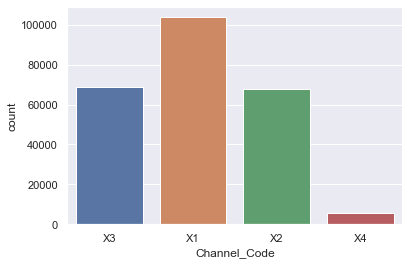

In [9]:
sns.set(style="darkgrid")
sns.countplot(df_train['Channel_Code'])

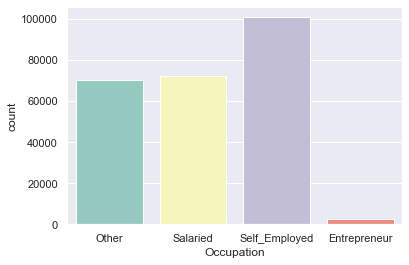

In [10]:
sns.countplot(df_train['Occupation'],palette="Set3")

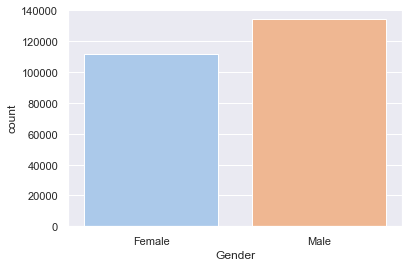

In [11]:
sns.countplot(df_train['Gender'],palette="pastel")

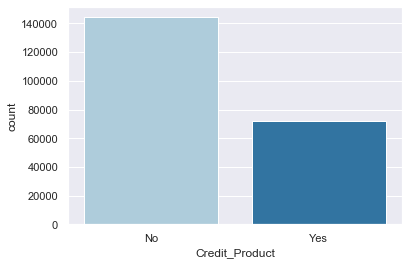

In [12]:
sns.set(style="darkgrid")
sns.countplot(df_train['Credit_Product'],palette="Paired")

<h4 style="font-family:Georgia, serif;color:blue" align='Left'>According to the above exploratory, the Credit_product column has null values. Filling the NaN rows backwords for the best fit</h4>

In [16]:
#Training Dataset
df_train['Credit_Product'] = df_train['Credit_Product'].fillna(method="bfill")

#Testing Dataset
df_test['Credit_Product'] = df_test['Credit_Product'].fillna(method="bfill")

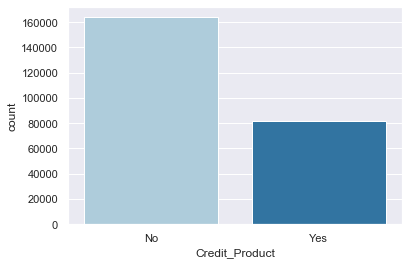

In [17]:
sns.set(style="darkgrid")
sns.countplot(df_train['Credit_Product'],palette="Paired")

In [18]:
#Scalling the Age for Training data

df_train.loc[df_train['Age'] <= 20, 'Age'] = 0
df_train.loc[(df_train['Age'] > 20) & (df_train['Age'] <= 60), 'Age'] = 1
df_train.loc[(df_train['Age'] > 60) & (df_train['Age'] <= 80), 'Age'] = 2
df_train.loc[ df_train['Age'] > 80, 'Age'] = 3

#Scalling the Age for Testing data

df_test.loc[df_test['Age'] <= 20, 'Age'] = 0
df_test.loc[(df_test['Age'] > 20) & (df_test['Age'] <= 60), 'Age'] = 1
df_test.loc[(df_test['Age'] > 60) & (df_test['Age'] <= 80), 'Age'] = 2
df_test.loc[ df_test['Age'] > 80, 'Age'] = 3

<h4 style="font-family:Georgia, serif;color:blue" align='Justify'>Setting the ID column as an Index and Splitting the dataframe into feature columns and target column</h4>

In [19]:
#Training Dataset
df_train.set_index("ID",inplace=True)
df_train_features = df_train.drop(["Is_Lead"],axis=1)
df_train_target = df_train["Is_Lead"]

#Testing Dataset
df_test.set_index("ID",inplace=True)

<h4 style="font-family:Georgia, serif;color:blue" align='Justify'>Converting the object columns into the numberical columns. For that Encoding the categorical columns using Label Encoder</h4>

In [20]:
#For Training dataset
label_columns = []
print("Categorical columns in the training dataset")
for col in df_train_features.select_dtypes('object').columns:
    print(col)
    label_columns.append(col)
    le = LabelEncoder()
    df_train_features[col] = le.fit_transform(df_train_features[col])
    
#For Testing dataset
label_columns_test = []
print("\nCategorical columns in the testing dataset")
for col2 in df_test.select_dtypes('object').columns:
    print(col2)
    label_columns_test.append(col2)
    le = LabelEncoder()
    df_test[col2] = le.fit_transform(df_test[col2])

Categorical columns in the training dataset
Gender
Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active

Categorical columns in the testing dataset
Gender
Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active


<h4 style="font-family:Georgia, serif;color:blue" align='Justify'>Since the value of Avg_Account_Balance is huge, applying to MinMaxScaler to scale the data</h4>

In [21]:
mms=MinMaxScaler()
mms_cols = ['Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Avg_Account_Balance']
#Training dataset
df_train_features[mms_cols] = mms.fit_transform(df_train_features[mms_cols])

#Testing Dataset
df_test[mms_cols] = mms.fit_transform(df_test[mms_cols]) 

In [22]:
for i in df_train_features:
    print(f'{i} : {df_train_features[i].unique()}')

Gender : [0 1]
Age : [2 1 3]
Region_Code : [0.52941176 0.79411765 0.58823529 0.94117647 0.32352941 0.44117647
 0.97058824 0.11764706 0.55882353 0.20588235 0.85294118 0.88235294
 0.05882353 1.         0.26470588 0.91176471 0.23529412 0.47058824
 0.29411765 0.70588235 0.17647059 0.73529412 0.67647059 0.5
 0.64705882 0.02941176 0.35294118 0.41176471 0.82352941 0.76470588
 0.38235294 0.         0.14705882 0.08823529 0.61764706]
Occupation : [0.33333333 0.66666667 1.         0.        ]
Channel_Code : [0.66666667 0.         0.33333333 1.        ]
Vintage : [0.28125   0.1953125 0.1484375 0.09375   0.203125  0.1015625 0.046875
 0.2421875 0.328125  0.90625   0.0546875 0.1875    0.390625  0.484375
 0.703125  0.0625    0.4375    0.109375  0.71875   0.3828125 0.625
 0.4296875 0.375     0.75      0.7578125 0.671875  0.421875  0.65625
 0.15625   0.25      0.3359375 0.296875  0.140625  0.859375  0.5703125
 0.578125  0.515625  0.46875   0.796875  0.6640625 0.8984375 0.53125
 0.5625    0.890625  0.812

In [23]:
df_train_target.value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

<h4 style="font-family:Georgia, serif;color:blue" align='Justify'>The above value_counts demonstrates that the dataset is unbalanced. To avoid this, the dataset is balanced using the SMOTE technique.</h4>

In [24]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
x_train, y_train = smote.fit_sample(df_train_features,df_train_target)

y_train.value_counts()

1    187437
0    187437
Name: Is_Lead, dtype: int64

In [25]:
x_train.shape

(374874, 9)

<h4 style="font-family:Georgia, serif;color:blue" align='Justify'>Setting some basic parameters for the model.</h4>

In [26]:
x_train = pd.DataFrame(x_train, columns = ["Gender","Age","Region_Code","Occupation","Channel_Code","Vintage","Credit_Product","Avg_Account_Balance","Is_Active" ])

In [27]:
x_train.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')

In [28]:
xtrain,xtest,ytrain,ytest = train_test_split(x_train, y_train, test_size=0.2,random_state=2021)

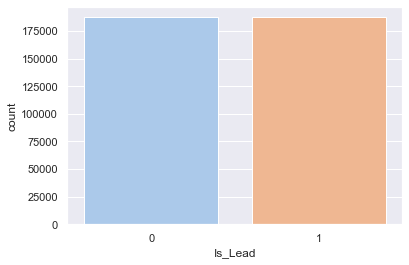

In [29]:
sns.countplot(y_train,palette="pastel")

<h4 style="font-family:Georgia, serif;color:blue" align='Justify'>Initiating the model design and training the dataset. </h4>

In [30]:
xgb_params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
}

In [31]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
classifier=xgboost.XGBClassifier()

In [32]:
random_search=RandomizedSearchCV(classifier,param_distributions=xgb_params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [33]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [34]:
from datetime import datetime
start_time = timer(None)
random_search.fit(xtrain,ytrain)
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[21:05:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 8 minutes and 27.89 seconds.


In [35]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [40]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,xtrain,ytrain,cv=10)

In [41]:
classifier.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [42]:
testData = pd.read_csv('test_mSzZ8RL.csv')
sample = pd.read_csv('sample_submission_eyYijxG.csv')

In [43]:
xgb_pred = classifier.predict(df_test)
xgb_pred = np.round(xgb_pred, decimals=2)

In [44]:
xgb_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [45]:
ypred_xgb_local = classifier.predict(xtest)
ypred_xgb_local = np.round(ypred_xgb_local)

In [46]:
print("Classification Report: \n", classification_report(ytest, ypred_xgb_local))

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83     37537
           1       0.84      0.80      0.82     37438

    accuracy                           0.83     74975
   macro avg       0.83      0.83      0.83     74975
weighted avg       0.83      0.83      0.83     74975



In [47]:
roc_auc_score(ytest, ypred_xgb_local)

0.8283107099985012

In [48]:
xgb_Submission = pd.DataFrame({
        "ID": testData['ID'],
        "Is_Lead": xgb_pred
    })

In [49]:
xgb_Submission['Is_Lead'].value_counts()

0    80683
1    24629
Name: Is_Lead, dtype: int64

In [50]:
xgb_Submission.to_csv('CreditCardLeadPrediction_xgb.csv',index=False)